In [61]:
import os
import time

new_directory_path = "C:/Users/rupsm/Robotics/FTC_SystemSim"  # Replace with your desired path

# Change the current working directory
os.chdir(new_directory_path)

# Get the current working directory (optional, for verification)
print(f"Current working directory before change: {os.getcwd()}")
#invoke all libraries
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import math as m

# this is a test to invoke locally
%run -i "C:\Users\rupsm\Robotics\FTC_SystemSim\FTC_SystemSim\Robotics\FTC_SystemSim\main.py"
# this is a test to invoke using git clone


Current working directory before change: C:\Users\rupsm\Robotics\FTC_SystemSim


In [62]:
# https://www.gobilda.com/content/spec_sheets/5203-2402-0027_spec_sheet.pdf
 # From this motor:
#Stall Torque @ 12VDC: 38.0 kg.cm (530 oz-in.)
#Stall Current @ 12VDC: 9.2A
#COnverting to SI
#rated rpm 220
volt=12
stall_torque=0.19 #NM
stall_current=9.2 #amps
Mecannum_wheel_radius=0.096 #96mm

# Assumotions for mechanical inputs
rated_rpm=319*0.8 #rpm 
num_motors=4 # number of motors
system_mass=10 #kg

# Assumotions based on playing field
start_coord=[0.29,0.29] # cartesian coordinates where the robot will start
end_coord=[1.4,2.1] # # cartesian coordinates where the robot will start

# assumptions for process times 
mean_intake=4 # in seconds
std_intake=4  # mean same as standard deviation
idle_time=4  # building idle time between cycles in seconds
mean_shoot=4 # mean time to shoot 
std_shoot=2  # standard deviation for time to shoot
proba_scoring=0.8 # probability for scoring
low_all_in=9    # min points if we match color per cycle
high_all_in=15  # max points if we match color per cycle
full_return_base=10  # end game


In [71]:
data_rows = []

for num_motors in range(2,8,2):
    for system_mass in range(10,25,5):
        for rated_rpm in range(220,420,100):
                for mean_intake in range(3,6,1):
                     for mean_shoot in range(2,5,1):
                            for mean_idle in range(2,5,1):
                                for proba_scoring in np.arange(0.6,1.2,0.2):
                            
                                        v_max = (Mecannum_wheel_radius*2*3.14*rated_rpm)/60    # max velocity expected to be acheived in m/s
                                        safety_factor=2 # for design considerations not used

                                        # eta calculated based on firs pass


                                        Torque_const=stall_torque/stall_current
                                        rated_torque=0.2 #(near max power)
                                        J=(system_mass)/num_motors
                                        a_max = (rated_torque/Mecannum_wheel_radius)/J    
                                        distance=np.sqrt((end_coord[0]-start_coord[0])**2+(end_coord[1]-start_coord[1])**2)


                                        # Example usage
                                        t, x, v, a = trapezoidal_motion_profile(distance, v_max, a_max,pl=None)
                                        current, torque=compute_motor_current(a, t, J,Torque_const, T_load=None,pl=None)
                                        copper_loss,iron_loss=compute_motor_losses(current,v,t, 0.01,1,0.01,pl=None)
                                        #animate(t,start_coord,end_coord,pts=100,filename="func_test.gif")

                                        intake_ucl, intake_lcl=calculate_control_limits(mean_intake, std_intake, sigma_multiplier=1)
                                        shoot_ucl, shoot_lcl=calculate_control_limits(mean_shoot, std_shoot, sigma_multiplier=1)


                                        mean_cycle_time=max(t)*2+mean_intake+mean_shoot+idle_time
                                        nom_allowable_cycle=np.floor(100/mean_cycle_time)
                                        nom_score=nom_allowable_cycle*proba_scoring*((high_all_in+low_all_in)*0.5)+full_return_base


                                        upper_cycle_time=max(t)*2+max(1.5*mean_intake,intake_ucl)+max(1.5*mean_shoot,shoot_ucl)+idle_time
                                        lower_allowable_cycle=np.floor(100/upper_cycle_time)
                                        low_score=lower_allowable_cycle*proba_scoring*((high_all_in+low_all_in)*0.5) +full_return_base


                                        lower_cycle_time=max(t)*2+max(0.75*mean_intake,intake_lcl)+max(0.75*mean_shoot,shoot_lcl)+idle_time
                                        upper_allowable_cycle=np.floor(100/lower_cycle_time)
                                        high_score=upper_allowable_cycle*proba_scoring*((high_all_in+low_all_in)*0.5)+full_return_base


                                        row_data = {
                                            'Number_Motors': num_motors,
                                            'System_Mass': system_mass,
                                            'RPM': rated_rpm,
                                            'Intake_time': mean_intake,
                                            'shoot_time': mean_shoot,
                                            'shooting_accuracy': proba_scoring,
                                            'idle_time': mean_idle,


                                            'Nominal_Allwable_Cycle': nom_allowable_cycle,
                                            'Nominal_Points': nom_score,
                                            'Nominal_Allwable_Cycle': lower_allowable_cycle,
                                            'Low_Points': low_score,
                                            'High_Allwable_Cycle': upper_allowable_cycle,
                                            'High_Points': high_score,


                                        }
                                        data_rows.append(row_data)



In [73]:
import pandas as pd


# Initialize an empty list to store row data

# Simulate an iterative process to generate data


# Create the DataFrame once all data is collected
df = pd.DataFrame(data_rows)

print(df)
df.to_csv('output_simulation.csv', index=False)


      Number_Motors  System_Mass  RPM  Intake_time  shoot_time  \
0                 2           10  220            3           2   
1                 2           10  220            3           2   
2                 2           10  220            3           2   
3                 2           10  220            3           2   
4                 2           10  220            3           2   
...             ...          ...  ...          ...         ...   
1453              6           20  320            5           4   
1454              6           20  320            5           4   
1455              6           20  320            5           4   
1456              6           20  320            5           4   
1457              6           20  320            5           4   

      shooting_accuracy  idle_time  Nominal_Allwable_Cycle  Nominal_Points  \
0                   0.6          2                     4.0            46.0   
1                   0.8          2                 

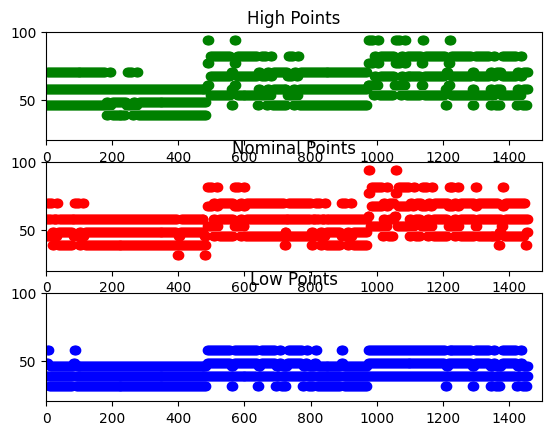

In [91]:
plt.subplot(3,1,1)
plt.scatter(df.index, df['High_Points'],c='green')
plt.axis([0,1500,20,100])
plt.title('High Points')

plt.subplot(3,1,2)
plt.scatter(df.index, df['Nominal_Points'],c='red')
plt.axis([0,1500,20,100])
plt.title('Nominal Points')

plt.subplot(3,1,3)
plt.scatter(df.index, df['Low_Points'],c='blue')
plt.axis([0,1500,20,100])
plt.title('Low Points')
plt.show()

